In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
import numpy as np
import math
import torch.utils.model_zoo as model_zoo

data_transform = transforms.Compose([
        #transforms.Resize(299),
        #transforms.CenterCrop(299),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                    	     std=[0.5, 0.5, 0.5])
    ])
train_dataset = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/artist_distribute_new',transform=data_transform)
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=128, shuffle=True)

print(train_dataset.class_to_idx)
#print(len(train_dataset[0]))

{'canaletto': 0, 'claude_monet': 1, 'george_romney': 2, 'jmw_turner': 3, 'john_robert_cozens': 4, 'paul_cezanne': 5, 'paul_gauguin': 6, 'paul_sandby': 7, 'peter_paul_rubens': 8, 'rembrandt': 9, 'richard_wilson': 10}


In [0]:
__all__ = ['ResNet', 'resnet18_cbam', 'resnet34_cbam', 'resnet50_cbam', 'resnet101_cbam',
           'resnet152_cbam']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.ca(out) * out
        out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)

        self.ca = ChannelAttention(planes * 4)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.ca(out) * out
        out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=11):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet18'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet34_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet34'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet50_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet50'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet101_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet101'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet152_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet152'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model



In [101]:
# In[]
net = resnet18_cbam()
net = torch.load('/content/drive/My Drive/Colab Notebooks/res18_40_128_old.pkl')
net = net.cuda()
criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()
optimizer = optim.Adam(net.parameters(), lr=0.001)

print("Start Training...")
LOSS = []
num_epoch = 35
for epoch in range(num_epoch):
    # 我们用一个变量来记录每10个batch的平均loss
    loss10 = 0.0
    # 我们的dataloader派上了用场
    for i, data in enumerate(trainloader):
        inputs, labels = data
        #print(labels)
        optimizer.zero_grad()
        inputs = inputs.cuda()
        labels = labels.cuda()
        #print(torch.cuda.current_device())
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss10 += loss.item()
        if i % 10 == 9:
            print('[Epoch %d, Batch %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss10 / 10))
            LOSS.append(loss10/10)
            loss10 = 0.0

print("Done Training!")



Start Training...
[Epoch 1, Batch    10] loss: 0.130
[Epoch 1, Batch    20] loss: 0.117
[Epoch 2, Batch    10] loss: 0.083
[Epoch 2, Batch    20] loss: 0.121
[Epoch 3, Batch    10] loss: 0.102
[Epoch 3, Batch    20] loss: 0.103
[Epoch 4, Batch    10] loss: 0.089
[Epoch 4, Batch    20] loss: 0.087
[Epoch 5, Batch    10] loss: 0.093
[Epoch 5, Batch    20] loss: 0.088
[Epoch 6, Batch    10] loss: 0.089
[Epoch 6, Batch    20] loss: 0.112
[Epoch 7, Batch    10] loss: 0.123
[Epoch 7, Batch    20] loss: 0.119
[Epoch 8, Batch    10] loss: 0.073
[Epoch 8, Batch    20] loss: 0.074
[Epoch 9, Batch    10] loss: 0.053
[Epoch 9, Batch    20] loss: 0.037
[Epoch 10, Batch    10] loss: 0.069
[Epoch 10, Batch    20] loss: 0.058
[Epoch 11, Batch    10] loss: 0.088
[Epoch 11, Batch    20] loss: 0.061
[Epoch 12, Batch    10] loss: 0.104
[Epoch 12, Batch    20] loss: 0.091
[Epoch 13, Batch    10] loss: 0.077
[Epoch 13, Batch    20] loss: 0.084
[Epoch 14, Batch    10] loss: 0.066
[Epoch 14, Batch    20] loss

In [102]:
# In[eval]
summ = 0
for ii in range(100):
  test_dataset = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/test_set',transform=data_transform)
  testloader = torch.utils.data.DataLoader(test_dataset,batch_size=46, shuffle=True)
  eval_loss = 0
  correct = 0
  total = 0
  for i, data in enumerate(testloader):
    inputs, labels = data
    #print(labels)
    
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    eval_loss += loss.item()
    total += labels.size(0)
    pred = torch.max(outputs, 1)[1]
    print('pred: ',pred,' labels: ',labels)
    correct += (pred == labels).sum().item()
    summ += (100 * correct / total)
  print('eval_loss: ',eval_loss)
  print('correct: ',correct)
  print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
print("total_acc: ", summ/100)

'''
test_dataset = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/test_set',transform=data_transform)
testloader = torch.utils.data.DataLoader(test_dataset,batch_size=46, shuffle=True)
eval_loss = 0
correct = 0
total = 0
for i, data in enumerate(testloader):
    inputs, labels = data
    #print(labels)
    
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    eval_loss += loss.item()
    total += labels.size(0)
    pred = torch.max(outputs, 1)[1]
    print('pred: ',pred,' labels: ',labels)
    correct += (pred == labels).sum().item()
print('eval_loss: ',eval_loss)
print('correct: ',correct)
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
'''

pred:  tensor([ 2,  0,  3, 10,  2,  8,  4,  4,  2,  9,  0,  4,  3,  1,  0,  0,  8,  9,
         6,  4,  3,  6,  7,  3,  1,  1,  0,  2,  2,  1,  7,  9,  2,  3,  2,  5,
        10,  2,  7,  6,  1,  5,  5,  9,  8,  6], device='cuda:0')  labels:  tensor([ 2,  0,  3,  3,  2,  8,  4,  4,  2,  9,  0,  4,  3,  1,  3,  3,  5,  9,
         1,  4,  3,  6,  7,  3,  1,  1, 10,  1,  2,  5,  7,  9,  2,  3,  2,  5,
        10,  2,  7,  6,  1,  6,  5,  9,  8,  3], device='cuda:0')
eval_loss:  0.9741269946098328
correct:  36
Accuracy of the network on the test images: 78 %
pred:  tensor([ 1, 10,  1,  5, 10,  2,  3,  3,  1,  7,  9,  4,  0,  3,  5,  4,  9,  1,
         2,  3,  3,  6,  2,  0,  9,  8,  3,  8,  9,  0,  1,  4,  2,  3,  3,  7,
         4,  6,  7,  8,  7,  2,  2,  2,  9,  6], device='cuda:0')  labels:  tensor([ 1, 10,  1,  5,  3,  2,  3,  3,  1,  7,  9,  4,  0,  3,  5,  4,  9,  5,
         2,  3,  3,  6,  2,  3,  9,  5,  3,  1,  8, 10,  1,  4,  2,  6,  0,  3,
         4,  6,  7,  8,  7,  2,  2,

"\ntest_dataset = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/test_set',transform=data_transform)\ntestloader = torch.utils.data.DataLoader(test_dataset,batch_size=46, shuffle=True)\neval_loss = 0\ncorrect = 0\ntotal = 0\nfor i, data in enumerate(testloader):\n    inputs, labels = data\n    #print(labels)\n    \n    inputs = inputs.cuda()\n    labels = labels.cuda()\n    outputs = net(inputs)\n    loss = criterion(outputs, labels)\n    eval_loss += loss.item()\n    total += labels.size(0)\n    pred = torch.max(outputs, 1)[1]\n    print('pred: ',pred,' labels: ',labels)\n    correct += (pred == labels).sum().item()\nprint('eval_loss: ',eval_loss)\nprint('correct: ',correct)\nprint('Accuracy of the network on the test images: %d %%' % (100 * correct / total))\n"

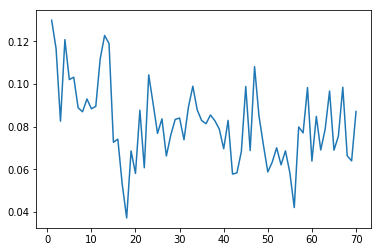

In [103]:
# In[可视化]
from matplotlib import pyplot as plt
x = np.linspace(1,len(LOSS),len(LOSS))
plt.plot(x,LOSS)
plt.show()

In [0]:
torch.save(net, '/content/drive/My Drive/Colab Notebooks/res18_40_128_new.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ChannelAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SpatialAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
